## MH4518 Group Project

Product: https://derivative.credit-suisse.com/ch/ch/en/detail/drop-back-certificate-s-p-500/CH1199361879/119936187


### 1. Initial Set-up

<ol>
<li> Set directories
<li> Install dependencies
<li> Import libraries
</ol>

NOTE: Ensure you are using the correct kernel to run the Jupyter Notebook with the correctly set root driectory.

In [59]:
import os, sys

# Set the root directory accordingly
ROOT_DIR = "d:/Coding/MH4518"
os.chdir(ROOT_DIR)
sys.path.append(ROOT_DIR)

# The data directory is set relative to root
DATA_DIR = os.path.join(ROOT_DIR, "./data")

In [60]:
# Install additional libraries using pip
#! pip install -r requirements.txt

# Or if you have Conda installed (reccommended)
# conda env create -f environment.yml

In [61]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_market_calendars as mcal

from numba import jit, njit
from nelson_siegel_svensson.calibrate import calibrate_ns_ols
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [62]:
# OPTIONAL: Suppresing the Deprecation Notices while using numba (reccommended)
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

### 2. Loading Data

The asset and product price data was collected and preprocessed using the scripts present in the `/data` directory.
<li> Start date: 09-08-2022
<li> End date: 09-11-2023
<br>

TODO: Update datasets (currently only till Oct 20)

In [63]:
# Load price data
asset_prices = pd.read_csv(os.path.join(DATA_DIR, "asset_prices.csv"))
asset_prices["date"] = pd.to_datetime(asset_prices["date"])
asset_prices = asset_prices.set_index("date")

product_prices = pd.read_csv(os.path.join(DATA_DIR, "product_prices.csv"))
product_prices["date"] = pd.to_datetime(product_prices["date"])
product_prices = product_prices.set_index("date")

# Sanity check
assert len(asset_prices) == len(product_prices)

In [64]:
# Load data on daily interest rate
interest_rates = pd.read_csv(os.path.join(DATA_DIR, "daily_interest_rates.csv"))
interest_rates["date"] = pd.to_datetime(interest_rates["date"])
interest_rates = interest_rates.set_index("date")

interest_rates.shape

(301, 13)

### 3. Payoff Function

In [65]:
def find_trigger_price(S_path, trigger):
    '''
    Returns the price that triggered the event, if it exists, else None.
    '''
    # Return the first price that triggers the event
    for price in S_path:
        if price <= trigger:
            return price
        
    return None


def calculate_payoff(S_path, Y_0 = 1000, rate = 0.0985, years = 3):
    '''
    Computes the payoff of a simulated path.
    '''
    S_0 = 3790.38   # From factsheet
    S_T = S_path[-1]
    S_t1 = find_trigger_price(S_path, trigger = 0.90*S_0)   # 3,411.3420 
    S_t2 = find_trigger_price(S_path, trigger = 0.85*S_0)   # 3,221.8230
    S_t3 = find_trigger_price(S_path, trigger = 0.80*S_0)   # 3,032.3040

    # Edge Case
    if(S_t3 == 0 or S_t2 == 0 or S_t1 == 0):
        return 0

    # 1. Fixed returns independent of trigger events
    Y_T = (0.55*Y_0) * (S_T/S_0)

    # 2. Adjusted returns after trigger events
    if S_t3 is not None:
        multiplier = (S_T/S_t1 + S_T/S_t2 + S_T/S_t3)
    elif S_t2 is not None:
        multiplier = (S_T/S_t1 + S_T/S_t2)
    elif S_t1 is not None:
        multiplier = (S_T/S_t1)
    else:
        multiplier = 0.0
    Y_T += (0.15*Y_0) * multiplier

    # 3. Daily accrued interest of 9.85% p.a.
    if S_t3 is not None:
        principal = 0.0
    elif S_t2 is not None:
        principal = (0.15*Y_0)
    elif S_t1 is not None:
        principal = (0.30*Y_0)
    else:
        principal = (0.45*Y_0)
    Y_T += principal * (1 + rate * years)
    
    assert Y_T >= 0.0   # Sanity Check
    return Y_T

In [66]:
# OPTIONAL: Testing the payoff function with values in the factsheet (Flawed, all triggers are hit)
S_0 = 3790.38
S_path_partial = [3790.41, 3800.15, 3373.44, 4000.00, 3183.92, 2994.40]
S_T = [0.0, 2653.27, 3032.3, 3411.34, 3790.38, 4169.42, 4548.46, 4927.49]

for final_closing_price in S_T:
    S_path = S_path_partial + [final_closing_price]
    payoff = calculate_payoff(S_path)

    print(f"S_T = {final_closing_price} \t   Performance of Asset = {100*(final_closing_price - S_0)/S_0:.2f}% \t Performance of Certificate = {(payoff - 1000)/10:.2f}% \t Payoff = {payoff:.2f}")

S_T = 0.0 	   Performance of Asset = -100.00% 	 Performance of Certificate = -100.00% 	 Payoff = 0.00
S_T = 2653.27 	   Performance of Asset = -30.00% 	 Performance of Certificate = -23.91% 	 Payoff = 760.89
S_T = 3032.3 	   Performance of Asset = -20.00% 	 Performance of Certificate = -13.04% 	 Payoff = 869.59
S_T = 3411.34 	   Performance of Asset = -10.00% 	 Performance of Certificate = -2.17% 	 Payoff = 978.29
S_T = 3790.38 	   Performance of Asset = 0.00% 	 Performance of Certificate = 8.70% 	 Payoff = 1086.98
S_T = 4169.42 	   Performance of Asset = 10.00% 	 Performance of Certificate = 19.57% 	 Payoff = 1195.68
S_T = 4548.46 	   Performance of Asset = 20.00% 	 Performance of Certificate = 30.44% 	 Payoff = 1304.38
S_T = 4927.49 	   Performance of Asset = 30.00% 	 Performance of Certificate = 41.31% 	 Payoff = 1413.08


### 4. Geometric Brownian Motion

Implmentation of the Black-Scholes model for pricing. THe form derived from Ito's lemma was used.

In [67]:
@njit
def simulate_GBM(num_sim, S_0, r, sigma, delta_t, T, Z):  # NOTE: For exact GMB simply set r=mu while calling
  # Initializations
  v = r - 0.5*(sigma**2)
  num_periods = int(T/delta_t)
  S_matrix = np.zeros(shape=(num_sim, num_periods + 1), dtype=np.float64)

  # We are using the form derived by Ito's lemma 
  for i in range(num_sim):
    S_matrix[i][0] = S_0
    for j in range(1, num_periods + 1):
      log_diff = v*delta_t + (sigma*np.sqrt(delta_t) * Z[i][j-1])
      S_matrix[i][j] = S_matrix[i][j-1]*np.exp(log_diff)

  return S_matrix

### 5. Variance Reduction for GBM

Functions that implement,

<ol> 
<li> Antithetic Variates
<li> Control Variates
<li> Empirical Martingale Simulation
</ol>

In [68]:
@njit
def simulate_GBM_AV(num_sim, S_0, r, sigma, delta_t, T, Z):
  # Initializations
  v = r - 0.5*(sigma**2)
  num_periods = int(T/delta_t)
  S_matrix = np.full(shape=(num_sim, num_periods + 1), fill_value = S_0, dtype=np.float64)
  S_tilde_matrix = np.full(shape=(num_sim, num_periods + 1), fill_value = S_0, dtype=np.float64)

  # Ito's lemma form (just a bit more concise)
  for i in range(num_sim):
    S_matrix[i][0] = S_0
    S_tilde_matrix[i][0] = S_0
    for j in range(1, num_periods + 1):
        S_matrix[i][j] = S_matrix[i][j-1]*np.exp(v*delta_t + (sigma*np.sqrt(delta_t) * Z[i][j-1]))
        S_tilde_matrix[i][j] = S_tilde_matrix[i][j-1]*np.exp(v*delta_t - (sigma*np.sqrt(delta_t) * Z[i][j-1]))  # Negative Z(.)  
  
  return np.vstack((S_matrix, S_tilde_matrix))

In [69]:
@njit
def simulate_GBM_EMS(num_sim, S_0, r, sigma, delta_t, T, Z):
  # Initializations
  num_periods = int(T/delta_t)
  S_matrix = np.full(shape=(num_sim, num_periods + 1), fill_value = S_0, dtype=np.float64)
  Z_matrix = np.full(shape=(num_sim + 1, num_periods + 1), fill_value = S_0, dtype=np.float64)

  # Simulating the GBM path and set the first coloumn of S_matrix
  gbm_path = simulate_GBM(num_sim, S_0, r, sigma, delta_t, T, Z=Z)
  S_matrix[:, 0] = gbm_path[:, 0]
  
  # Correcting the path using EMS
  for j in range(1, num_periods+1):
    Z_matrix[:num_sim, j-1] = (S_matrix[:, j-1] * gbm_path[:, j])/gbm_path[:, j-1]
    Z_matrix[num_sim, j-1] = np.exp(-r * ((j-1) * delta_t)) * np.mean(Z_matrix[:num_sim, j-1])
    S_matrix[:, j] = (gbm_path[:, 0] * Z_matrix[:num_sim, j-1])/Z_matrix[num_sim, j-1]

  return S_matrix

CHECK: For the Control Variate whether we use the asset prices or product prices for the covariance step. Also check Z_1 and Z_2.

In [70]:
@jit  # Need to use some pythonic capabilities for this function
def simulate_GBM_CV(num_sim, S_0, r, sigma, delta_t, T, Z_pilot, Z_new, use_minimum=False):
  """
  N_1 == N_2 == num_sim in our implementation
  If use_minmum = True, we set S_T as the respective minimum price of for each GBM path
  """
  # Generating a pilot of N_1 prices
  gbm_path_pilot = simulate_GBM(num_sim, S_0, r, sigma, delta_t, T, Z_pilot)
  payoff_pilot = np.exp(-r*T)*np.apply_along_axis(func1d=calculate_payoff, axis=1, arr=gbm_path_pilot)

  # Calulating c*
  S_T_vector_pilot = [min(i) for i in gbm_path_pilot] if use_minimum else [i[-1] for i in gbm_path_pilot]
  covariance_matrix = np.cov(payoff_pilot, S_T_vector_pilot)
  c_star = -covariance_matrix[0][1]/(S_0**2 * np.exp(2*r*T) * (np.exp(sigma**2 * T) - 1))    # By the martingale property
  
  # Simulating N_2 new prices
  gbm_path_new = simulate_GBM(num_sim, S_0, r, sigma, delta_t, T, Z=Z_new)
  payoff_new = np.exp(-r*T)*np.apply_along_axis(func1d=calculate_payoff, axis=1, arr=gbm_path_new)
  
  # Finally, computing the control variates
  S_T_vector_new = [min(i) for i in gbm_path_new] if use_minimum else [i[-1] for i in gbm_path_new]
  payoff_CV = payoff_new + c_star * (S_T_vector_new - S_0 * np.exp(r*T))

  return payoff_CV

### 6. Backtesting GBM

We take 252 day long windows of data for each iteration.

eg: The first window begins on 9th August, 2022 and ends on 9th August, 2023 and we price the product on 10th August.

#### Parameters and Rolling Window

In [71]:
# Create a market calendar for date handling
nyse = mcal.get_calendar('NYSE')
product_lifetime = nyse.schedule(start_date='2022-07-14', end_date='2025-07-14')
print(len(product_lifetime))

753


In [72]:
# Parameters for each set of simulations
num_sim = 10000    # Push to 1,000,000
delta_t = 1/252
num_periods = len(product_lifetime)
T = num_periods/252

In [73]:
# One set of simulations for each date in [start_date, end_date]
window_size = 252
start_date = pd.to_datetime("2023-08-09")
end_date = pd.to_datetime("2022-10-20")
#end_date = pd.to_datetime("2022-11-09")  # TODO: Update dataset

simulation_dates = asset_prices.index[asset_prices.index >= start_date]

In [74]:
# We shall sample a window of size 252 from the historical data (EXCLUDING the current date)
backtest_windows = []

for window_end_date in simulation_dates:
    # Jump back 252 points
    window_start_index = asset_prices.index.get_loc(window_end_date) - window_size
    assert window_start_index >= 0

    # Slice the dataset according to the window
    window_start_date = asset_prices.index[window_start_index]
    window_asset_data = asset_prices[(asset_prices.index >= window_start_date) & (asset_prices.index < window_end_date)]    # CHECK THIS with TA

    # Collect all the windows
    assert len(window_asset_data) == window_size
    backtest_windows.append(np.array(window_asset_data["value"]))

print(f"Collected data for {len(backtest_windows)} windows of size {window_size} each.")

Collected data for 52 windows of size 252 each.


#### Interpolating the Interest Rate Curves

In [75]:
maturities = np.array([1/12, 2/12, 3/12, 4/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30])
interest_rates.columns = maturities

# The 4 month interest rate is a bit sparse
interest_rates = interest_rates.dropna(how='any', axis=1)
maturities = interest_rates.columns.to_numpy()
interest_rates.shape

(301, 12)

In [76]:
curves = []
for date in simulation_dates:
    try:
        interest_rate = interest_rates.loc[date].to_numpy()
        curve_fit, status = calibrate_ns_ols(maturities, interest_rate)
        curves.append(curve_fit)

    except KeyError:
        # Handle the case where the rate is not found
        print(f"Rate not found for date {date}, using the rate from the previous date.")    # CHECK THIS!
        previous_date = interest_rates.index[interest_rates.index <= date].max()
        corrected_rate = interest_rates.loc[previous_date].to_numpy()
        curve_fit, status = calibrate_ns_ols(maturities, corrected_rate)
        curves.append(curve_fit)

    except Exception as e:
        print(f"An error occurred for date {date}: {e}")

Rate not found for date 2023-10-09 00:00:00, using the rate from the previous date.


#### Helper Functions

In [77]:
def get_lognormal_statistics(prices, delta_t):
  log_data = np.log(prices)
  log_returns = log_data[1:] - log_data[:-1]
  mu = np.mean(log_returns)/delta_t
  sigma = np.std(log_returns)/np.sqrt(delta_t)
  return mu, sigma

In [78]:
# Generating a common random variable/common randomness matrix
Z_matrix = np.random.normal(0, 1, size=(len(simulation_dates), num_sim, num_periods))

#### Running the Simulations aka The Exciting Part

In [ ]:
# GBM without Variance Reduction
GBM_expected_values = []

for date, prices in zip(simulation_dates, backtest_windows):
  # Convert date to index (so we can lookup prices and interest rate curves)
  date_index = simulation_dates.get_loc(date)

  # Estimate r
  delta = len(product_lifetime[date:])
  tau = delta / 252
  curve_fit = curves[date_index]
  r = curve_fit(tau)/100

  # Calulcate mu and sigma (we discard mu)
  _, sigma = get_lognormal_statistics(prices, delta_t)

  # Simulate prices, calculate payoff and expected value
  simulated_prices = simulate_GBM(num_sim, prices[-1], r, sigma, delta_t, tau, Z=Z_matrix[date_index])
  payoffs = np.exp(-r*tau)*np.apply_along_axis(func1d=calculate_payoff, axis=1, arr=simulated_prices)
  expected_value = np.mean(payoffs)
  GBM_expected_values.append(expected_value)

In [ ]:
# GBM with Antithetic Variance Reduction
GBM_AV_expected_values = []

for date, prices in zip(simulation_dates, backtest_windows):
  # Convert date to index (so we can lookup prices and interest rate curves)
  date_index = simulation_dates.get_loc(date)

  # Estimate r
  delta = len(product_lifetime[date:])
  tau = delta / 252
  curve_fit = curves[date_index]
  r = curve_fit(tau)/100

  # Calulcate mu and sigma (we discard mu)
  _, sigma = get_lognormal_statistics(prices, delta_t)
  
  # Simulate prices, calculate payoff and expected value
  simulated_prices = simulate_GBM_AV(int(num_sim/2), prices[-1], r, sigma, delta_t, tau, Z=Z_matrix[date_index])
  payoffs = np.exp(-r*tau)*np.apply_along_axis(func1d=calculate_payoff, axis=1, arr=simulated_prices)
  expected_value = np.mean(payoffs)
  GBM_AV_expected_values.append(expected_value)

In [ ]:
# GBM with EMS Variance Reduction
GBM_EMS_expected_values = []

for date, prices in zip(simulation_dates, backtest_windows):
  # Convert date to index (so we can lookup prices and interest rate curves)
  date_index = simulation_dates.get_loc(date)

  # Estimate r
  delta = len(product_lifetime[date:])
  tau = delta / 252
  curve_fit = curves[date_index]
  r = curve_fit(tau)/100

  # Calulcate mu and sigma (we discard mu)
  _, sigma = get_lognormal_statistics(prices, delta_t)

  # Simulate prices, calculate payoff and expected value
  simulated_prices = simulate_GBM_EMS(num_sim, prices[-1], r, sigma, delta_t, tau, Z=Z_matrix[date_index])
  payoffs = np.exp(-r*tau)*np.apply_along_axis(func1d=calculate_payoff, axis=1, arr=simulated_prices)
  expected_value = np.mean(payoffs)
  GBM_EMS_expected_values.append(expected_value)

In [ ]:
# GBM with Control Variate Variance Reduction
GBM_CV_expected_values = []

for date, prices in zip(simulation_dates, backtest_windows):
  # Convert date to index (so we can lookup prices and interest rate curves)
  date_index = simulation_dates.get_loc(date)

  # Estimate r
  delta = len(product_lifetime[date:])
  tau = delta / 252
  curve_fit = curves[date_index]
  r = curve_fit(tau)/100

  # Calulcate mu and sigma (we discard mu)
  _, sigma = get_lognormal_statistics(prices, delta_t)

  # We need to sample another Z, independently, for simulating the initial pilot prices
  Z_pilot = np.random.normal(0, 1, size=(num_sim, num_periods))
  Z_new = Z_matrix[date_index]
  assert Z_pilot.shape == Z_new.shape

  # Simulate payoff and expected value
  payoffs = simulate_GBM_CV(num_sim, prices[-1], r, sigma, delta_t, tau, Z_pilot=Z_pilot, Z_new=Z_new)
  expected_value = np.mean(payoffs)
  GBM_CV_expected_values.append(expected_value)

In [ ]:
# GBM with Control Variate Variance Reduction, using minimum price as control
GBM_CV_Min_expected_values = []

for date, prices in zip(simulation_dates, backtest_windows):
  # Convert date to index (so we can lookup prices and interest rate curves)
  date_index = simulation_dates.get_loc(date)

  # Estimate r
  delta = len(product_lifetime[date:])
  tau = delta / 252
  curve_fit = curves[date_index]
  r = curve_fit(tau)/100

  # Calulcate mu and sigma (we discard mu)
  _, sigma = get_lognormal_statistics(prices, delta_t)

  # We need to sample another Z, independently, for simulating the initial pilot prices
  Z_pilot = np.random.normal(0, 1, size=(num_sim, num_periods))
  Z_new = Z_matrix[date_index]
  assert Z_pilot.shape == Z_new.shape

  # Simulate payoff and expected value
  payoffs = simulate_GBM_CV(num_sim, prices[-1], r, sigma, delta_t, tau, Z_pilot=Z_pilot, Z_new=Z_new, use_minimum=True)
  expected_value = np.mean(payoffs)
  GBM_CV_Min_expected_values.append(expected_value)

#### Plotting the Results aka The Moment of Truth

In [ ]:
simulation_reults = pd.DataFrame(index=simulation_dates)
product_prices = product_prices[product_prices.index >= start_date]

# For some reason the product was priced on Labour Day
try:
    product_prices = product_prices.drop(pd.to_datetime("2023-09-04"))  # Labour day nonesense
except:
    print("Labour Day price was already removed!")
assert len(product_prices) == len(simulation_reults)

# Gather data into a single dataframe
simulation_reults['Actual'] = product_prices["value"]
simulation_reults['GBM'] = GBM_expected_values
simulation_reults['AV'] = GBM_AV_expected_values
simulation_reults['EMS'] = GBM_EMS_expected_values
simulation_reults['CV'] = GBM_CV_expected_values
simulation_reults['CV_Min'] = GBM_CV_Min_expected_values

simulation_reults.head()

In [ ]:
plt.figure(figsize=(14,8))
plt.title('Backtesting ',fontdict={"fontsize":18})

simulation_reults['Actual'].plot(legend=True)
simulation_reults['GBM'].plot(legend=True,style="--")
simulation_reults['AV'].plot(legend=True,style="--")
simulation_reults['EMS'].plot(legend=True,style="--")
simulation_reults['CV'].plot(legend=True,style="--")
#simulation_reults['CV_Min'].plot(legend=True,style="--")

plt.xlabel('Market Days')
plt.ylabel('Derivative Price in USD')

#### Hmm maybe the Error Decreased?

In [ ]:
mean_abs_error=mean_absolute_error(simulation_reults['Actual'].to_list(),simulation_reults['GBM'].to_list())
mean_sq_error=mean_squared_error(simulation_reults['Actual'].to_list(),simulation_reults['GBM'].to_list())
print(f'Mean Absolute Error for GBM:\t\t{mean_abs_error}')
print(f'Mean Squared Error for GBM:\t\t{mean_sq_error}\n')

mean_abs_error=mean_absolute_error(simulation_reults['Actual'].to_list(),simulation_reults['AV'].to_list())
mean_sq_error=mean_squared_error(simulation_reults['Actual'].to_list(),simulation_reults['AV'].to_list())
print(f'Mean Absolute Error for GBM with AV:\t{mean_abs_error}')
print(f'Mean Squared Error for GBM with AV:\t{mean_sq_error}\n')

mean_abs_error=mean_absolute_error(simulation_reults['Actual'].to_list(),simulation_reults['EMS'].to_list())
mean_sq_error=mean_squared_error(simulation_reults['Actual'].to_list(),simulation_reults['EMS'].to_list())
print(f'Mean Absolute Error for GBM with EMS:\t{mean_abs_error}')
print(f'Mean Squared Error for GBM with EMS:\t{mean_sq_error}\n')   

mean_abs_error=mean_absolute_error(simulation_reults['Actual'].to_list(),simulation_reults['CV'].to_list())
mean_sq_error=mean_squared_error(simulation_reults['Actual'].to_list(),simulation_reults['CV'].to_list())
print(f'Mean Absolute Error for GBM with CV:\t{mean_abs_error}')
print(f'Mean Squared Error for GBM with CV:\t{mean_sq_error}\n')

mean_abs_error=mean_absolute_error(simulation_reults['Actual'].to_list(),simulation_reults['CV_Min'].to_list())
mean_sq_error=mean_squared_error(simulation_reults['Actual'].to_list(),simulation_reults['CV_Min'].to_list())
print(f'Mean Absolute Error with CV using min:\t{mean_abs_error}')
print(f'Mean Squared Error with CV using min:\t{mean_sq_error}\n')

### 7. Estimating Sensitivities

The simulation results from the three scenarios; S, S+h, and S-h, are used to estimate delta and gamma for each time point by Finite-difference Method.

In [110]:
@njit
def simulate_GBM_finite_difference(num_sim, S_0, r, sigma, delta_t, T, Z, h):
  # Initializations
  v = r - 0.5*(sigma**2)
  num_periods = int(T/delta_t)

  # Generate S+h and S-h matrices too
  S_matrix = np.full(shape=(num_sim, num_periods + 1), fill_value = S_0, dtype=np.float64)
  S_plus_h_matrix = np.full(shape=(num_sim, num_periods + 1), fill_value = S_0 + h, dtype=np.float64)
  S_minus_h_matrix = np.full(shape=(num_sim, num_periods + 1), fill_value = S_0 - h, dtype=np.float64)

  # We are using the form derived by Ito's lemma 
  for i in range(num_sim):
    for j in range(1, num_periods + 1):
      log_diff = v*delta_t + (sigma*np.sqrt(delta_t) * Z[i][j-1])
      S_matrix[i][j] = S_matrix[i][j-1]*np.exp(log_diff)
      S_plus_h_matrix[i][j] = S_plus_h_matrix[i][j-1]*np.exp(log_diff)
      S_minus_h_matrix[i][j] = S_minus_h_matrix[i][j-1]*np.exp(log_diff)

  return S_matrix, S_plus_h_matrix, S_minus_h_matrix

In [118]:
# Simulating Delta with Finite-difference method
GBM_deltas = []
GBM_gammas = []

for date, prices in zip(simulation_dates, backtest_windows):
  # Convert date to index (so we can lookup prices and interest rate curves)
  date_index = simulation_dates.get_loc(date)

  # Estimate r
  delta = len(product_lifetime[date:])
  tau = delta / 252
  curve_fit = curves[date_index]
  r = curve_fit(tau)/100

  # Calulcate mu and sigma (we discard mu)
  _, sigma = get_lognormal_statistics(prices, delta_t)

  # Set h (CHECK THIS)
  #h = 0.005
  h = prices[-1] * (10**(-6))

  # Simulate prices and base payoffs
  simulated_prices, simulated_prices_plus_h, simulated_prices_minus_h = simulate_GBM_finite_difference(num_sim, prices[-1], r, sigma, delta_t, tau, Z=Z_matrix[date_index], h=h)
  payoffs = np.apply_along_axis(func1d=calculate_payoff, axis=1, arr=simulated_prices)
  payoffs_plus_h = np.apply_along_axis(func1d=calculate_payoff, axis=1, arr=simulated_prices_plus_h)
  payoffs_minus_h = np.apply_along_axis(func1d=calculate_payoff, axis=1, arr=simulated_prices_minus_h)

  # Caclulate and collect expected values
  expected_value = np.exp(-r*tau)*np.mean(payoffs)
  expected_value_plus_h = np.exp(-r*tau)*np.mean(payoffs_plus_h)
  expected_value_minus_h = np.exp(-r*tau)*np.mean(payoffs_minus_h)

  # Compute Delta and Gamma (using FDM)
  delta = (expected_value_plus_h - expected_value_minus_h)/(2*h)
  gamma = (expected_value_plus_h - 2*expected_value + expected_value_minus_h)/(h**2)

  GBM_deltas.append(delta)
  GBM_gammas.append(gamma)

In [119]:
# Create a DataFrame for results
greeks_results = pd.DataFrame(index=simulation_dates)
greeks_results['Delta'] = GBM_deltas
greeks_results['Gamma'] = GBM_gammas

print('Delta: ', np.mean(GBM_deltas), '\nGamma: ', np.mean(GBM_gammas))

Delta:  0.17471552428357343 
Gamma:  0.7139091053656483


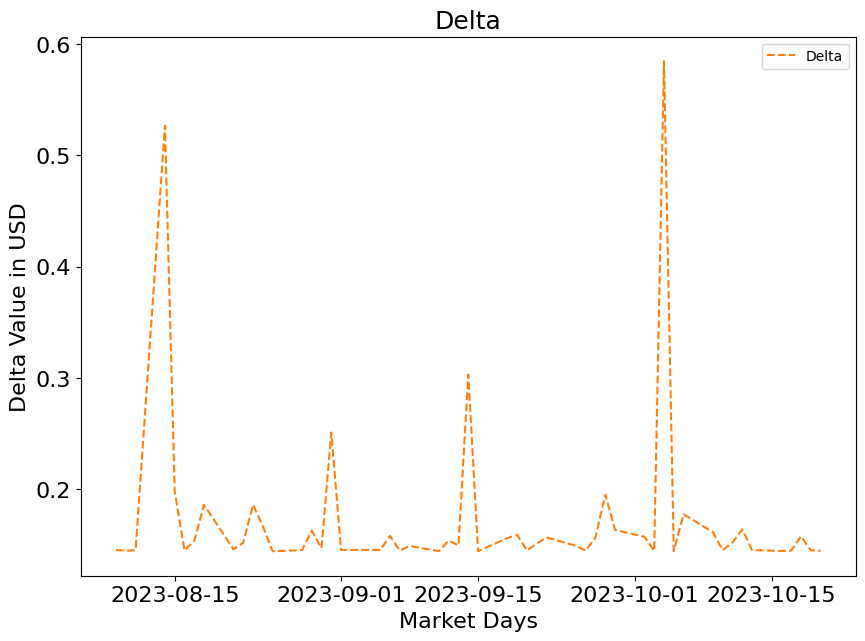

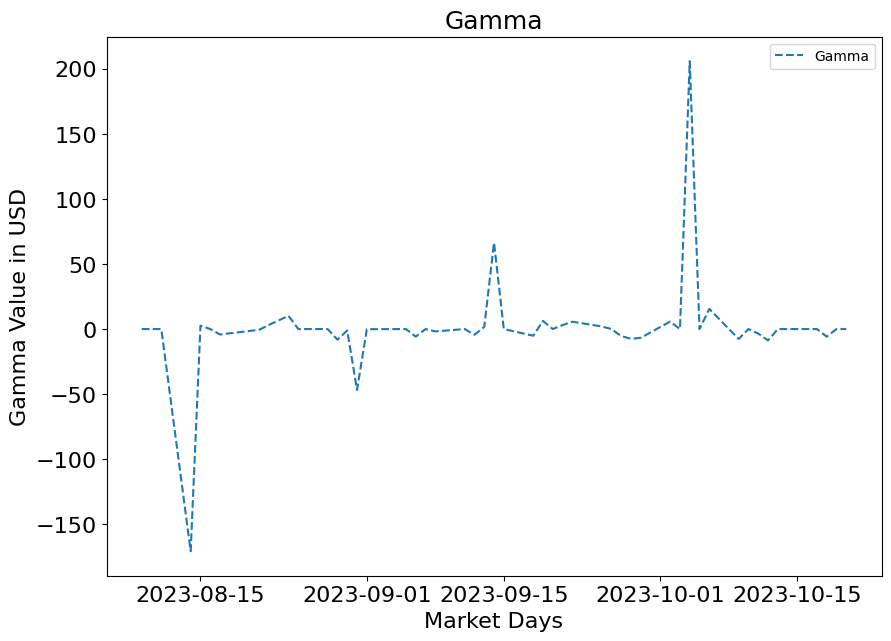

In [120]:
# Plot Delta
plt.figure(figsize=(10, 7))
plt.plot(greeks_results.index, greeks_results['Delta'], label='Delta', color='tab:orange', linestyle='--')
plt.title('Delta', fontsize=18)
plt.xlabel('Market Days', fontsize=16)
plt.ylabel('Delta Value in USD', fontsize=16)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.legend()
plt.show()

# Plot Gamma
plt.figure(figsize=(10, 7))
plt.plot(greeks_results.index, greeks_results['Gamma'], label='Gamma', color='tab:blue', linestyle='--')
plt.title('Gamma', fontsize=18)
plt.xlabel('Market Days', fontsize=16)
plt.ylabel('Gamma Value in USD', fontsize=16)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.legend()
plt.show()

### 8. Short Rate Interest Model